# Backscattering normalization

Ref: 10.1109/tgrs.2012.2205264, https://ieeexplore.ieee.org/document/6264094 (Mladenova (2013))

In [1]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# Geospatial
import fiona
import xarray as xr
import hydroeval as he
# import geopandas as gpd
# from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyswarms.utils.plotters import plot_cost_history
from pyswarms.utils.functions.single_obj import sphere

In [8]:
def skew_gauss(x, A, mean, dev, alpha,):
    """Skew, not-normalized and shifted gaussian distribution.

    References:
    - https://www.wolframalpha.com/input?i=skew+gaussian+distribution
    - https://stackoverflow.com/questions/15400850/scipy-optimize-curve-fit-unable-to-fit-shifted-skewed-gaussian-curve
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html

    """
    
    import math
    import scipy.special as sp
    
    pdf = (1/(dev*np.sqrt(2*np.pi)))*np.exp(-pow((x-mean),2)/(2*pow(dev,2)))
    cdf = sp.erfc((-alpha*(x-mean))/(dev*np.sqrt(2)))
    return A*pdf*cdf

#-----------------------------------------------------------------------------

def gauss(x, A, mean, dev):
    """Not-normalized, shifted gaussian distribution."""
    
    import math
    
    pdf = (1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))
    return A*pdf

#-----------------------------------------------------------------------------

def HIST_norm(ref_mean, ref_std, obs:list):
    """HIST normalization
    Ref. Mladenova, 2013, https://ieeexplore.ieee.org/document/6264094
    
    obs = [value, mean, std]
    """
    value, mean, std = obs
    return ref_mean+ref_std/std*(value-mean)

#-----------------------------------------------------------------------------

In [75]:
df = pd.read_csv('..\\Data\\Golden_GEE_2014-22.csv', delimiter='\t', index_col=0)
df.index=df.index.astype('datetime64[ns]'); df

,Angle[°],Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],VV_var[lin],VV[dB],VH[dB],VV_var[dB],VH_var[dB]
Date,,,,,,,,,,,,
2014-10-12 07:00:00,41.268929,Budrio_half-right,95,DESCENDING,0.019403,0.000044,0.165803,0.004212,-7.804083,-17.121268,0.110340,0.009797
2014-10-12 07:00:00,41.268929,Budrio_half-right,95,DESCENDING,0.019403,0.000044,0.165803,0.004212,-7.804083,-17.121268,0.110340,0.009797
2014-10-24 07:00:00,41.271503,Budrio_half-right,95,DESCENDING,0.006721,0.000008,0.081771,0.000852,-10.874000,-21.725451,0.045247,0.005138
2014-11-17 06:00:00,41.107655,Budrio_half-right,95,DESCENDING,0.022583,0.000047,0.180793,0.003206,-7.428182,-16.462105,0.077004,0.009036
2014-11-29 06:00:00,41.106918,Budrio_half-right,95,DESCENDING,0.020082,0.000070,0.190233,0.004016,-7.207139,-16.972004,0.091675,0.015033
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-12 18:00:00,37.399632,Budrio_half-right,117,ASCENDING,0.008295,0.000025,0.062336,0.000590,-12.052590,-20.812039,0.041081,0.013176
2022-11-16 06:00:00,31.267229,Budrio_half-right,168,DESCENDING,0.024676,0.000096,0.215107,0.006513,-6.673451,-16.077300,0.131493,0.016926
2022-11-23 06:00:00,41.307030,Budrio_half-right,95,DESCENDING,0.026612,0.000089,0.244474,0.006738,-6.117674,-15.749171,0.119698,0.014454


In [76]:
n=0
for orb in [168, 117, 95]:
    leng = len(df[df.Orb==orb]) 
    print(leng)
    n+=leng
print(n)

384
382
385
1151


Save plot? [y/n] y


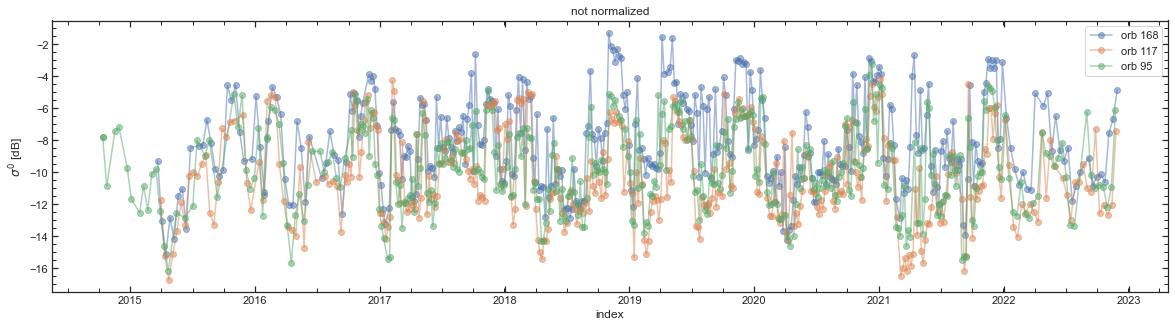

In [77]:
# Timeseries

plot_name = 'sigma_norm_2014-22_'
opt_save = True if input('Save plot? [y/n]')=='y' else False
plt.figure(figsize=(20,5))

for orb in [168, 117, 95]:
    plt.plot(df[df.Orb==orb]['VV[dB]'], alpha=.5, marker='o', linestyle='-', label=f'orb {orb}')
plt.ylabel(r'$\sigma^0$ [dB]')
plt.xlabel('index')
plt.legend(loc='best')
plt.title('not normalized')
if opt_save: plt.savefig(plot_name+'plot_not-norm.png', dpi=300)
plt.show()

In [78]:
normdict = dict()
nnormdict = dict()

for orb in [168, 117, 95]:
    d = dict()
    for pol in ['VV','VH']:
        d[f'{pol}']      = df.loc[df.Orb==orb][f'{pol}[dB]'].values
        d[f'{pol}_mean'] = np.mean(df.loc[df.Orb==orb][f'{pol}[dB]'].values)
        d[f'{pol}_std']  = np.std(df.loc[df.Orb==orb][f'{pol}[dB]'].values)
    d['angle'] = df.loc[df.Orb==orb][f'Angle[°]'].values
    normdict[orb] = d
    
normdf = pd.DataFrame.from_dict(normdict, orient='index'); normdf

statsnorm = normdf.drop(columns=['VV','VH','angle']); statsnorm

,VV_mean,VV_std,VH_mean,VH_std
168,-8.059031,2.820688,-18.192002,3.415233
117,-10.231410,2.796976,-18.727557,3.298258
95,-9.738871,2.563697,-19.084662,3.286345


In [79]:
for orb in [168, 117, 95]:
    d = dict()
    for pol in ['VV', 'VH']:
        d[f'{pol}']      = HIST_norm(
            normdf.loc[95][f'{pol}_mean'],
            normdf.loc[95][f'{pol}_std'],
            [
                normdf.loc[orb][pol],
                normdf.loc[orb][f'{pol}_mean'],
                normdf.loc[orb][f'{pol}_std'],
            ]
                 )
        d[f'{pol}_mean'] = np.mean(d[f'{pol}'])
        d[f'{pol}_std']  = np.std(d[f'{pol}'])
    nnormdict[orb] = d
    
nnormdf = pd.DataFrame.from_dict(nnormdict, orient='index'); nnormdf

,VV,VV_mean,VV_std,VH,VH_mean,VH_std
168,"[-10.876745484734904, -14.311268768204558, -16...",-9.738871,2.563697,"[-16.37963081561594, -18.40568704905876, -19.7...",-19.084662,3.286345
117,"[-11.122016194116036, -14.31136937792597, -15....",-9.738871,2.563697,"[-18.677730251206587, -19.473548764076025, -18...",-19.084662,3.286345
95,"[-7.80408295413925, -7.80408295413925, -10.874...",-9.738871,2.563697,"[-17.121268107674776, -17.121268107674776, -21...",-19.084662,3.286345


In [80]:
def hist_gauss_fit(data, nbins, hist_kwargs, fitline_kwargs,
                   title, density=True, opt_save=False, opt_name='hist_fit',
                  ):
    
    def gauss(x, A, mean, dev):
        """Not-normalized, shifted gaussian distribution."""
        import math
        return A*(1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))

    counts, bins, pads = plt.hist(data, bins=nbins, density=True, **hist_kwargs)
    fit_bounds = [ [0,min(bins),0], [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))] ]
    popt, pcov = curve_fit(gauss, bins[:-1], counts, method='trf',bounds=fit_bounds, maxfev=1000)
    A, mean, dev = popt[0], popt[1], popt[2]
    x = np.linspace(min(data), max(data), 50)
    fit = gauss(x, A, mean, dev)
    plt.plot(x, fit, **fitline_kwargs)
    ylabel = 'Density' if density else 'Counts';    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)
    if opt_save: plt.savefig(opt_name+'.png', dpi=300)
    return counts, bins, pads

Save plots? [y/n] n


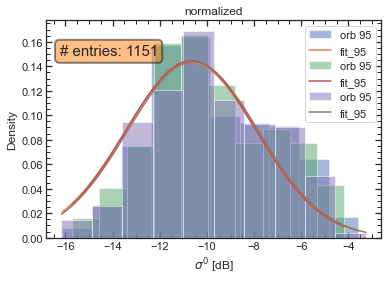

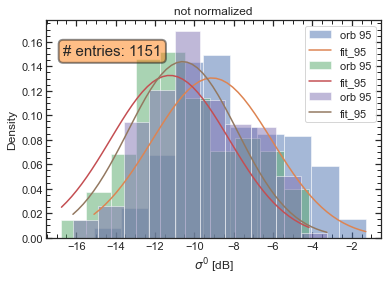

In [81]:
# Histograms plots

hist_kwargs={'alpha':.5, 'label':f'orb {orb}'}
fitline_kwargs={'linestyle':'-', 'label':f'fit_{orb}'}
opt_save=True if input('Save plots? [y/n]')=='y' else False

plt.figure()
for orb in [168, 117, 95]:
    data = nnormdf['VV'][orb]
    counts, bins, pads = hist_gauss_fit(data, nbins=10, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                   title='normalized', density=True, opt_save=opt_save, opt_name='hist_2014-22_fit_norm',)
    plt.xlabel(r'$\sigma^0$ [dB]')
t = plt.text(np.min(bins)+2, 0.9*np.max(counts),
             f'# entries: {len(df.index)}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

plt.figure()
for orb in [168, 117, 95]:
    data = normdf['VV'][orb]
    hist_gauss_fit(data, nbins=10, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                   title='not normalized', density=True, opt_save=opt_save, opt_name='hist_2014-22_fit_not-norm',)
    plt.xlabel(r'$\sigma^0$ [dB]')
t = plt.text(np.min(bins)+2, 0.9*np.max(counts),
             f'# entries: {len(df.index)}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

In [82]:
df['VV_norm[dB]']= df.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VV_mean'][95],
        statsnorm['VV_std'][95],
        [   
            x['VV[dB]'],    
            statsnorm['VV_mean'][x.Orb],    
            statsnorm['VV_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

df['VH_norm[dB]']= df.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VH_mean'][95],
        statsnorm['VH_std'][95],
        [   
            x['VH[dB]'],    
            statsnorm['VH_mean'][x.Orb],    
            statsnorm['VH_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

In [83]:
df

,Angle[°],Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],VV_var[lin],VV[dB],VH[dB],VV_var[dB],VH_var[dB],VV_norm[dB],VH_norm[dB]
Date,,,,,,,,,,,,,,
2014-10-12 07:00:00,41.268929,Budrio_half-right,95,DESCENDING,0.019403,0.000044,0.165803,0.004212,-7.804083,-17.121268,0.110340,0.009797,-7.804083,-17.121268
2014-10-12 07:00:00,41.268929,Budrio_half-right,95,DESCENDING,0.019403,0.000044,0.165803,0.004212,-7.804083,-17.121268,0.110340,0.009797,-7.804083,-17.121268
2014-10-24 07:00:00,41.271503,Budrio_half-right,95,DESCENDING,0.006721,0.000008,0.081771,0.000852,-10.874000,-21.725451,0.045247,0.005138,-10.874000,-21.725451
2014-11-17 06:00:00,41.107655,Budrio_half-right,95,DESCENDING,0.022583,0.000047,0.180793,0.003206,-7.428182,-16.462105,0.077004,0.009036,-7.428182,-16.462105
2014-11-29 06:00:00,41.106918,Budrio_half-right,95,DESCENDING,0.020082,0.000070,0.190233,0.004016,-7.207139,-16.972004,0.091675,0.015033,-7.207139,-16.972004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-12 18:00:00,37.399632,Budrio_half-right,117,ASCENDING,0.008295,0.000025,0.062336,0.000590,-12.052590,-20.812039,0.041081,0.013176,-11.408157,-21.161616
2022-11-16 06:00:00,31.267229,Budrio_half-right,168,DESCENDING,0.024676,0.000096,0.215107,0.006513,-6.673451,-16.077300,0.131493,0.016926,-8.479531,-17.049766
2022-11-23 06:00:00,41.307030,Budrio_half-right,95,DESCENDING,0.026612,0.000089,0.244474,0.006738,-6.117674,-15.749171,0.119698,0.014454,-6.117674,-15.749171


Save plot? [y/n] y


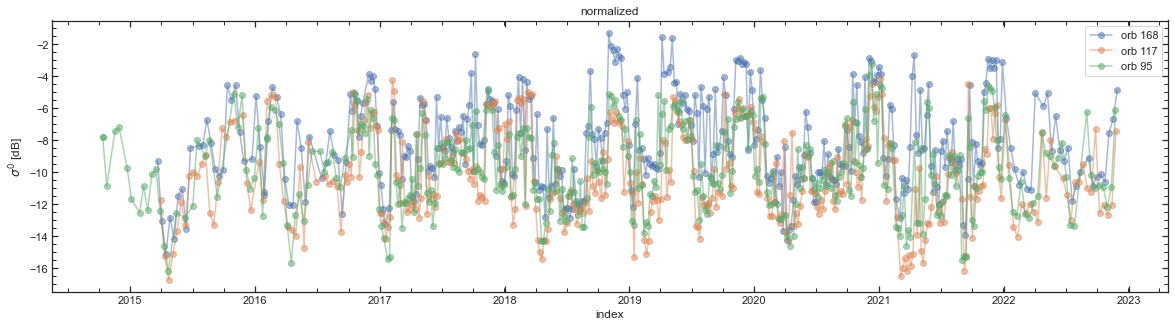

In [85]:
# Timeseries

plot_name = 'sigma_norm_2014-22_'
opt_save = True if input('Save plot? [y/n]')=='y' else False

plt.figure(figsize=(20,5))
for orb in [168, 117, 95]:
    plt.plot(df[df.Orb==orb].index, df[df.Orb==orb]['VV[dB]'], alpha=.5, marker='o', linestyle='-', label=f'orb {orb}')
plt.ylabel(r'$\sigma^0$ [dB]')
plt.xlabel('index')
plt.legend(loc='best')
plt.title('normalized')
if opt_save: plt.savefig(plot_name+'plot_norm.png', dpi=300)
plt.show()

In [68]:
filename = f'..\\Data\\Golden_GEE_2014-22_norm.csv'
if input(f"Wanna save in Data directory? File has name: {filename}. [y/n] ")=='y':
    df.to_csv(filename, sep = '\t')

Wanna save in Data directory? File has name: ..\Data\Golden_GEE_2014-22_norm.csv. [y/n]  y
